# Pitching airfoil example 2, with FPM and masked integration

This notebook will solve the flow about a pitching airfoil with a semicircular leading edge and wedge-shaped trailing edge. This case was studied experimentally by Yuanhang Zhu at UVa

In [1]:
using MassivelySeparatedFlows
using ViscousFlow

In [2]:
using Plots
pythonplot()

#=
This is for purposes of rotating the plots, from the body-fixed coordinate system in which they are solved,
to the inertial coordinate system.
=#
import PythonPlot.matplotlib as mpl
using PythonPlot.PythonCall
anim = pyimport("matplotlib.animation")

┌ Warning: `PythonPlot` 1.0.3 is not compatible with this version of `Plots`. The declared compatibility is 1 - 1.0.2.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends.jl:55


Python: <module 'matplotlib.animation' from '/Users/jeff/JuliaProjects/MassivelySeparatedFlows/.CondaPkg/env/lib/python3.11/site-packages/matplotlib/animation.py'>

Let's define a macro that allows us to visualize the kinematics
of the body from the perspective of the inertial reference frame.

In [3]:
macro animate_motion(b,m,dt,tmax,xlim,ylim)
    return esc(quote
            bc = deepcopy($b)
            t0, x0 = 0.0, init_motion_state(bc,$m)
            dxdt = zero(x0)
            x = copy(x0)
            @gif for t in t0:$dt:t0+$tmax
                motion_rhs!(dxdt,x,($m,bc),t)
                global x += dxdt*$dt
                update_body!(bc,x,$m)
                plot(bc,xlims=$xlim,ylims=$ylim)                    
            end every 5
        end)
end

@animate_motion (macro with 1 method)

Set the Reynolds number and the CFL number

In [4]:
my_params=Dict()
my_params["Re"] = 1500  # This is not really the Reynolds number, but really just 1/viscosity. See below, where the actual Reynolds number is computed
my_params["CFL"] = 0.35
my_params["freestream angle"] = 0.0

0.0

Create a domain big enough to hold the vorticity. We will loosen the grid Re a bit.

In [5]:
xlim = (-0.5,3.0)
ylim = (-1.0,1.0)
my_params["grid Re"] = 8.0
nthreads = min(length(Sys.cpu_info()),6)
g = setup_grid(xlim,ylim,my_params,nthreads_max=nthreads)

PhysicalGrid{2}((665, 384), (98, 192), 0.005333333333333333, ((-0.5173333333333333, 3.0186666666666664), (-1.0186666666666666, 1.0186666666666666)), 6)

## Create the body

In [6]:
"""
    circle_wedge(len,thick,Δs)

Return the coordinates on an airfoil shape consisting of a semicircular leading edge
and wedge-shaped trailing edge
"""
function circle_wedge(len,thick,Δs)
   x0, y0 = 0.0, 0.0

    d = len - 0.5*thick
    β = asin(0.5*thick/d)
    smax = (d-0.5*thick*sin(β))/cos(β)
    θmin = π/2 - β
    θmax = 3π/2 + β

    Δθ = Δs/(0.5*thick)
    nθ = ceil(Int,(θmax-θmin)/Δθ)
    nt = ceil(Int,smax/Δs)

    s = range(0,smax,length=nt+1)
    θ = range(θmin,θmax,length=nθ+1)
    xt = x0 .+ d .- s*cos(β)
    yt = s*sin(β)
    xc = x0 .+ 0.5*thick*cos.(θ)
    yc = 0.5*thick*sin.(θ)

    x = vcat(xt[1:end-1],xc[1:end-1],reverse(xt)[1:end-1])
    y = vcat(yt[1:end-1],yc[1:end-1],-reverse(yt)[1:end-1])
    
    return x, y
end

circle_wedge

In [7]:
Δs = surface_point_spacing(g,my_params)

len = 1.0
thick = 0.119058809*len # matches the shape of Yuanhang's aspect ratio

x, y  = circle_wedge(len,thick,Δs)
body = BasicBody(x,y)

X = MotionTransform([0.0,0],0.0)
transform_body!(body,X)

Basic pointwise-specified body with 279 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Plot it, just to check.

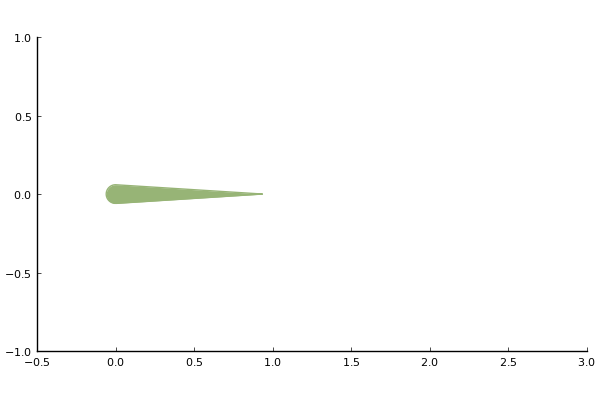

In [8]:
plot(body,xlim=xlim,ylim=ylim)

### The joint placement
We must specify the joint, attaching body 1 (the child) to the inertial system (body 0, the parent). We need
a more detailed form of the `Joint` function now. In this form, we need
to specify how the joint is attached to each body, and how each of its
degrees of freedom move. We will do this piece by piece to explain it.
More details can be found in the documentation for [RigidBodyTools.jl](https://github.com/JuliaIBPM/RigidBodyTools.jl).

To place the joint, we need to specify its position in both the parent's
and the child's coordinate systems. In the parent's system, we can just
place it at the origin, with no rotation. For the child, we place
the joint where we want it on the body (in its own system). $(0,0)$ is the center of the body.

In [9]:
parent_body, child_body = 0, 1
Xp = MotionTransform([0,0],0) # transform from inertial system to joint
xpiv = [0.0,0.0] 
Xc = MotionTransform(xpiv,0.0)

2d motion transform, x = [0.0, 0.0], R = [1.0 0.0; -0.0 1.0]

### The kinematics
We are creating a joint that has three potential degrees of freedom (angle, x, y),
called a `FreeJoint2d`. However, only the angle will be allowed to move. This is assigned oscillatory kinematics.

In [10]:
f_Hz = 2.4 # frequency in Hz
U_ms = 0.125 # free stream in m/s
c_m = 0.08 # chord length in m
f_red = f_Hz*c_m/U_ms

f = 1/4
Ω = 2π*f # Flapping angular frequency

Tp = 2π/Ω # Period of flapping
Δα = 5π/180 # Amplitude of pitching
ϕα = π/2 # Pitching phase
adof = OscillatoryDOF(Δα,Ω,ϕα,0.0)

Oscillatory kinematics (amplitude = 0.08726646259971647, ang freq = 1.5707963267948966, phase = 1.5707963267948966, mean velocity = 0.0)

Set the freestream speed to match the reduced frequency

In [11]:
my_params["freestream speed"] = f*len/f_red

0.16276041666666666

In [12]:
# so the Re = Ωc^2/ν is
Re_Ω = my_params["Re"]*len^2*Ω

# and Re = Uc/ν is
Re_U = my_params["Re"]*len*my_params["freestream speed"]

println("Reynolds number based on freestream speed is ",Re_U)

Reynolds number based on freestream speed is 244.140625


Keep the x and y coordinates fixed

In [13]:
xdof = ConstantVelocityDOF(0)
ydof = ConstantVelocityDOF(0)

Constant velocity kinematics (velocity = 0.0)

We put the kinematics into a vector. The degrees of freedom are always ordered `[rotation, x, y]`.

In [14]:
dofs = [adof,xdof,ydof]

3-element Vector{AbstractPrescribedDOFKinematics}:
 Oscillatory kinematics (amplitude = 0.08726646259971647, ang freq = 1.5707963267948966, phase = 1.5707963267948966, mean velocity = 0.0)
 Constant velocity kinematics (velocity = 0.0)
 Constant velocity kinematics (velocity = 0.0)

Finally, create the joint and the motion structure.

In [15]:
joint = Joint(FreeJoint2d,parent_body,Xp,child_body,Xc,dofs)
m = RigidBodyMotion(joint,body)

1 linked system(s) of bodies
   1 bodies
   1 joints


Now animate the motion for a complete cycle (4 time units)

[ Info: Saved animation to /Users/jeff/JuliaProjects/MassivelySeparatedFlows/notebooks/tmp.gif


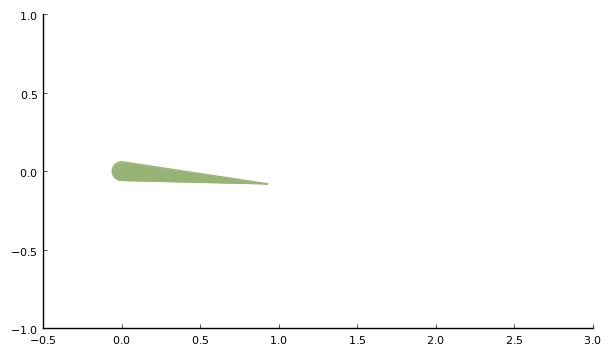

Plots.AnimatedGif("/Users/jeff/JuliaProjects/MassivelySeparatedFlows/notebooks/tmp.gif")
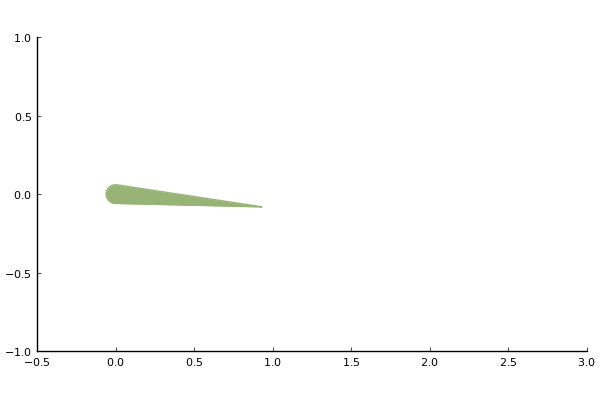

In [16]:
@animate_motion body m Tp/200 Tp xlim ylim

### Boundary condition functions

In [17]:
function my_vsplus(t,x,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsplus,x,base_cache,motions,t)
  return vsplus
end

# This is for specifying zero velocity inside the body
function my_vsminus(t,x,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

Dict{String, Function} with 2 entries:
  "interior" => my_vsminus
  "exterior" => my_vsplus

### Construct the system structure
Here, we supply both the motion, the boundary condition functions, and the reference body as additional arguments.

In [18]:
sys = viscousflow_system(g,body,phys_params=my_params,bc=bcdict,motions=m,reference_body=1);

### Set up the initial conditions
This is done the usual way

In [19]:
u0 = init_sol(sys)
tspan = (0.0,40.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 665, ny = 384) cell grid of type Float64 data
  Number of Dual nodes: (nx = 665, ny = 384), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.08726646259971647, 0.0, 0.0])

In [20]:
Δt = timestep(u0,sys)

0.0114688

### Solve the problem
Here, we will advance it for one flapping period

In [21]:
step!(integrator,Tp)

### Plot it
Plot the vorticity field in the coordinate system of the body

#### To rotate the plot to its inertial coordinate system

In [22]:
function get_trans_data(sol::ODESolution,sys::ILMSystem,t::Real)
    α = aux_state(sol(t))[1]*180/pi
    trans_data = mpl.transforms.Affine2D().rotate_deg(α)
end

get_trans_data (generic function with 1 method)

In [23]:
function pyplot_field!(ax::Py,f::GridData,sol::ODESolution,sys::ILMSystem,t::Real;cmap=mpl.colormaps["RdBu"].reversed(),levels=range(-2.5,2.5,length=30))
    
    #f = field(sol,sys,t)
    
    g = sys.base_cache.g
    x, y = coordinates(f,g)
    
    pts = points(sys)
    xb = [pts.u;]
    yb = [pts.v;]
    

    ax.set_aspect("equal")
    
    trans_data = get_trans_data(sol,sys,t) + ax.transData
    co = ax.contour(x,y,f',levels=levels,transform=trans_data,zorder=1,cmap=cmap)
    bo = ax.fill(xb,yb,color="black",transform=trans_data,zorder=2)
    
    co, bo
end

pyplot_field! (generic function with 1 method)

In [24]:
function animate_vort(i)
    for tp in p1[1].collections
        tp.remove()
    end
    
    for tp in ax.patches
        tp.remove()
    end
    
    iskip = 7 # plot every iskip time step
    t = sol.t[iskip*i+1]
    
    w = vorticity(sol,sys,t)
    co, bo = pyplot_field!(ax,w,sol,sys,t;cmap=mpl.colormaps["RdBu"].reversed())
    p1[1] = co
    p2[1] = bo
    
    return p1[1].collections + p2[1]
end

animate_vort (generic function with 1 method)

### Create a masking region, fixed in the inertial frame

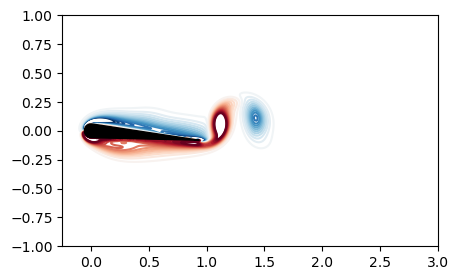

In [25]:
sol = integrator.sol

fig, ax = PythonPlot.subplots(figsize=(5,3))

t = Tp
w = vorticity(sol,sys,t)
co, bo = pyplot_field!(ax,w,sol,sys,t)
ax.set_xlim(-0.25,3.0)
ax.set_ylim(-1.0,1.0)
p1 = [co]
p2 = [bo]
display(fig)

In [26]:
ani = anim.FuncAnimation(fig,animate_vort,frames=floor(Int,length(sol.t)/7),interval=40)

Python: <matplotlib.animation.FuncAnimation object at 0x2e8cae6d0>

In [55]:
#ani.save("yuanhang-newcase-2.gif", bitrate=-1)

### Compute the auxiliary potentials
We only need to do this once.

In [27]:
xlim_min, xlim_max = xlim
ylim_min, ylim_max = ylim
buffer = 0.1
halfx = 0.5*(xlim_max - xlim_min) - buffer
halfy = 0.5*(ylim_max - ylim_min) - buffer
xc, yc = 0.5*(xlim_max+xlim_min), 0.5*(ylim_max+ylim_min)
frame = Rectangle(halfx,halfy,Δs)
tframe = MotionTransform([xc,yc],0.0)
transform_body!(frame,tframe)

bl = BodyList([body,frame])

BodyList(Body[Basic pointwise-specified body with 279 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
, Closed polygon with 4 vertices and 1366 points
   Current position: (1.25,0.0)
   Current angle (rad): 0.0
])

In [28]:
function get_vnplus(base_cache,phys_params) end
function get_vnminus(base_cache,phys_params) end

potbcdict = Dict("exterior"=>get_vnplus,"interior"=>get_vnminus)

prob = NeumannPoissonProblem(g,bl,bc=potbcdict)
potsys = construct_system(prob);

In [29]:
function get_vnminus(base_cache,phys_params)
    vnminus = zeros_surface(base_cache)
    return vnminus
end

get_vnminus (generic function with 1 method)

In [30]:
get_vnplus(base_cache,phys_params) = dfdn_nx(base_cache,phys_params)
ϕ̃x, dϕ̃x, sx, dsx = solve(prob,potsys)

get_vnplus(base_cache,phys_params) = dfdn_ny(base_cache,phys_params)
ϕ̃y, dϕ̃y, sy, dsy = solve(prob,potsys)

get_vnplus(base_cache,phys_params) = dfdn_xcrossn(base_cache,phys_params)
ψ, dfrot, srot, dsrot = solve(prob,potsys);

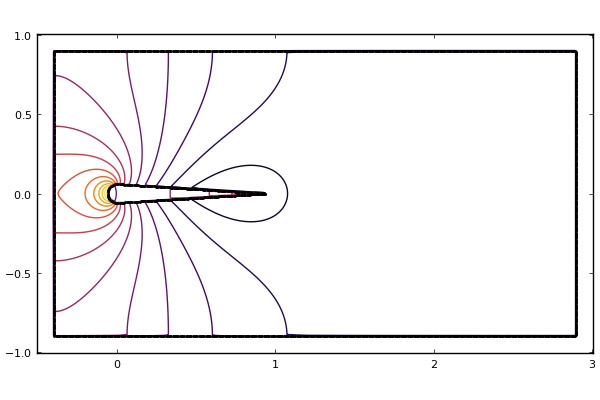

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [31]:
plot(ϕ̃x,potsys)

### Compute the integral of Q with the potential fields over whole domain
Note that this excludes inside the body since Q is zero inside there. We will also transform the force and moment to the inertial coordinate system.

In [32]:
t = Tp # Evaluate at time t = Tp
Q = Qcrit(sol,sys,t);

First, calculate the force components in the body coordinates. Moment here is computed about the origin of the body's coordinate system.

In [33]:
f̃xQ = integrate(-2ϕ̃x∘Q,sys)
f̃yQ = integrate(-2ϕ̃y∘Q,sys)
momQ = integrate(-2ψ∘Q,sys)

0.00497331581165686

We wish to transform this into force/moment in inertial coordinates. First, we assemble the components into a Plucker vector, which facilitates the transforms.

In [34]:
f̃Q = PluckerForce{2}(angular=momQ,linear=[f̃xQ,f̃yQ])

2d Plucker force vector, M = 0.00497331581165686, F = [0.0005999994070378747, 0.010890070091537574]

Now, we need to construct the current transform of the body to the inertial system.

In [35]:
x = aux_state(integrator.sol(t))
Xl = body_transforms(x,m) # Gets the list of transforms at this time
Xf_from_ref_to_i = force_transform_from_A_to_B(Xl,1,0)

2d force transform, x = [0.0, 0.0], R = [0.9961947951904071 0.08715463289775723; -0.08715463289775723 0.9961947951904071]

Now perform the transform, and get the individual components:

In [36]:
fQ = Xf_from_ref_to_i*f̃Q
momQ, fxQ, fyQ = fQ

2d Plucker force vector, M = 0.00497331581165686, F = [0.001546836347467264, 0.010796338416389193]

### Masking for integration purposes
Here, we will compute an integral over a defined region that is fixed in the inertial frame of reference. To do so, we create a mask shape, and transform the mask shape to the body-fixed coordinate system at the instant we need it, since this is where we actually compute the integral.

First, we create the mask shape and place it where we want it in the inertial frame

In [37]:
mask_shape = Rectangle(0.75,0.5,Δs)
Xi_to_mask = MotionTransform([1.75,0],0.0) # X represents the transform from the inertial system to the mask's system

mask_shape_in_inertial_frame = Xi_to_mask(mask_shape)

Closed polygon with 4 vertices and 670 points
   Current position: (1.75,0.0)
   Current angle (rad): 0.0


Show the mask in the inertial frame

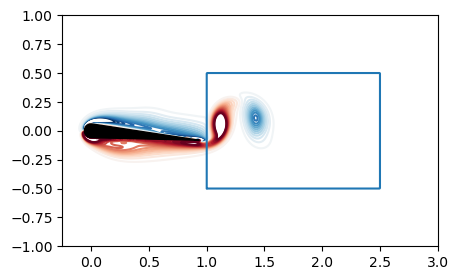

In [38]:
ax.plot(mask_shape_in_inertial_frame.x,mask_shape_in_inertial_frame.y)
display(fig)

Transform the mask shape from its own frame to the body frame

In [39]:
x = aux_state(integrator.sol(t))
reference_body = 1
Xbody_to_mask = rebase_from_inertial_to_reference(Xi_to_mask,x,m,reference_body)

mask_shape_in_body_frame = Xbody_to_mask(mask_shape)

# Create a mask of the same data type as Q
integ_region = mask(Q,mask_shape_in_body_frame,g);

The integral of the mask itself is simply its area:

In [40]:
integrate(integ_region,sys)

1.5000004521855088

Here's a plot of $-2\phi_x Q$ in the body frame

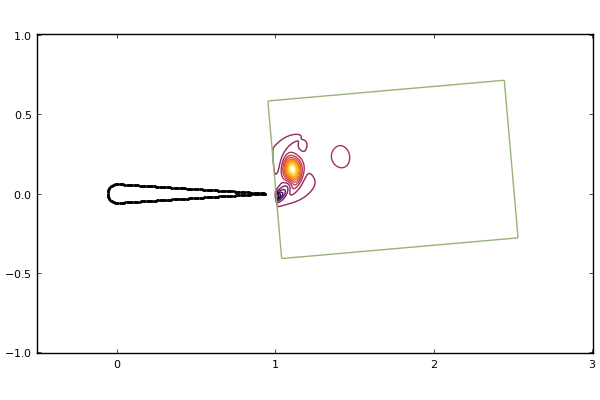

In [41]:
plot(-2ϕ̃x∘Q∘integ_region,sys)
plot!(mask_shape_in_body_frame,fill=false)

And here's a plot of it in the inertial frame

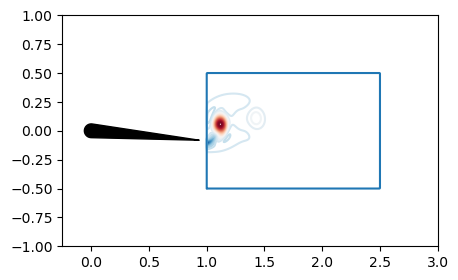

In [42]:
fig, ax = PythonPlot.subplots(figsize=(5,3))

Qfx = -2ϕ̃x∘Q∘integ_region

co, bo = pyplot_field!(ax,Qfx,sol,sys,t,levels=range(minimum(Qfx),maximum(Qfx),length=30))
ax.plot(mask_shape_in_inertial_frame.x,mask_shape_in_inertial_frame.y)
ax.set_xlim(-0.25,3.0)
ax.set_ylim(-1.0,1.0)
display(fig)

And here are the integrals

In [45]:
f̃xQ = integrate(-2ϕ̃x∘Q∘integ_region,sys)
f̃yQ = integrate(-2ϕ̃y∘Q∘integ_region,sys)
momQ = integrate(-2ψ∘Q∘integ_region,sys)

0.0015715949466066947

### Plot the forces and moments
The solution is expressed in co-rotating coordinates. To get the force and
moment in inertial coordinates, we
make use of the `axes` keyword, setting it to 0. The moment is computed
about the center of the body's coordinate system, but we can change that behavior
by using the `force_reference` keyword, setting it to 0, for example,
to compute the moment about the origin of the inertial system.

In [46]:
mom, fx, fy = force(sol,sys,1,axes=0);

Plot these

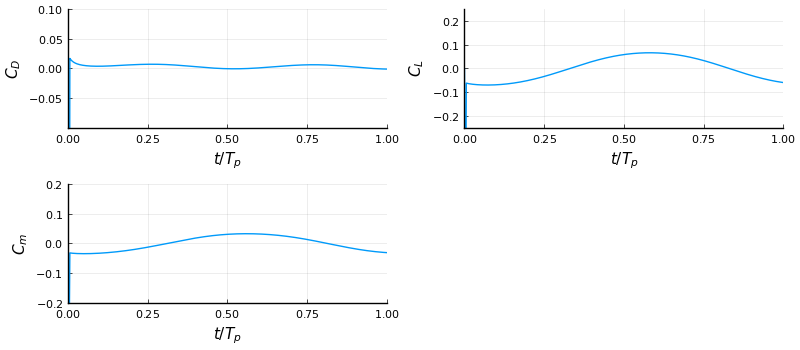

In [47]:
plot(
plot(sol.t/Tp,2*fx/Ω^2,xlim=(0,Inf),ylim=(-0.1,0.1),xlabel="\$t/T_p\$",ylabel="\$C_D\$",legend=:false),
plot(sol.t/Tp,2*fy/Ω^2,xlim=(0,Inf),ylim=(-0.25,0.25),xlabel="\$t/T_p\$",ylabel="\$C_L\$",legend=:false),
plot(sol.t/Tp,2*mom/Ω^2,xlim=(0,Inf),ylim=(-0.2,0.2),xlabel="\$t/T_p\$",ylabel="\$C_m\$",legend=:false),
    size=(800,350)
)